<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/AI_MasterThesis_Recommendations_LFM2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 49.8 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
     |████████████████████████████████| 880 kB 70.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0cbf29d4efc218e4f89606b7a62540e9594f80aca0ba60b979416004d4c735c0
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch import nn
from transformers import BertModel
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import gc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Read Data

## Datasets

In [121]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col, item2pos, user2id):
        super(LFM2bDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        # inputs = tokenizer.encode_plus(
        #     text1, 
        #     None,
        #     add_special_tokens=True,
        #     max_length = self.max_length,
        #     pad_to_max_length=True   
        #)

        inputs = tokenizer.encode_plus(
                text1, 
                add_special_tokens=True,
                padding='max_length',
                max_length = self.max_length,
                return_tensors='pt',
                truncation=True,
                return_attention_mask=True
                )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids_lyrics': ids.flatten(),
            'attention_mask_lyrics': mask.flatten(),
            'user_id': torch.tensor(user_id, dtype=torch.long),
             'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [122]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDatasetMulitpleText(Dataset):
    def __init__(self, data_all,tokenizer,max_length, item2pos, user2id):
        super(LFM2bDatasetMulitpleText, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index]['lyrics_cleaned']
        text2 = self.data_all.iloc[index]['tags']
        text3 = self.data_all.iloc[index]['abstract']
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs1 = tokenizer.encode_plus(
            text1, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids1 = inputs1["input_ids"]
        mask1 = inputs1["attention_mask"]

        inputs2 = tokenizer.encode_plus(
            text2, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids2 = inputs2["input_ids"]
        mask2 = inputs2["attention_mask"]

        inputs3 = tokenizer.encode_plus(
            text3, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids3 = inputs1["input_ids"]
        mask3 = inputs1["attention_mask"]

        return {
            'input_ids_lyrics': torch.tensor(ids1, dtype=torch.long),
            'attention_mask_lyrics': torch.tensor(mask1, dtype=torch.long),
            'input_ids_tags': torch.tensor(ids2, dtype=torch.long),
            'attention_mask_tags': torch.tensor(mask2, dtype=torch.long),
            'input_ids_abstract': torch.tensor(ids3, dtype=torch.long),
            'attention_mask_abstract': torch.tensor(mask3, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long),
            'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


## Read Data: Lyrics 

In [7]:
# data_tracks_lyrics = pd.read_csv("music/data_tracks_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
# data_tracks_tags_lyrics = pd.read_csv("music/data_tracks_tags_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna().drop_duplicates('track_id')
# data_bio = pd.read_csv("music/data_artists_biography.txt", sep=",").drop(['Unnamed: 0'],axis=1).dropna()
# data_interaction = pd.read_csv("music/data_user_track_interaction_old.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

# data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_bio)
# data_interaction = data_interaction.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), on = 'track_id', how = 'inner').drop_duplicates()
# data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction[['track_id']], on = 'track_id', how = 'inner').drop_duplicates()

# data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

In [129]:
data_movies = pd.read_csv("movies/movies_abstracts.csv").drop(['Unnamed: 0'],axis=1).dropna()
data_interaction = pd.read_csv("movies/ratings.csv").drop(['timestamp'],axis=1)

data_movies = pd.merge(data_movies, data_interaction[['movieId']], 'inner').drop_duplicates()
data_interaction = pd.merge(data_interaction, data_movies[['movieId']], 'inner')

data_movies.columns = ['track_id', 'lyrics_cleaned', 'tags', 'abstract']
data_tracks_tags_lyrics = data_movies

data_interaction.columns = ['user_id', 'track_id', 'count']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


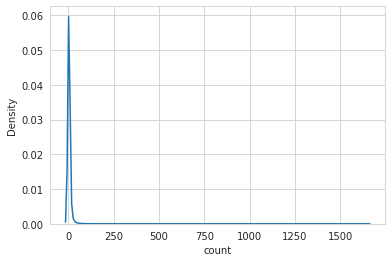

In [12]:
# import seaborn as sns
# sns.set_style('whitegrid')
# sns.kdeplot(data_interaction['count'], bw=0.5)

In [13]:
# # filter out playcount 1
# data_interaction = data_interaction[data_interaction['count'] != 1]

# data_interaction.loc[data_interaction['count']<2., 'count'] = 0.
# data_interaction.loc[data_interaction['count']>=2., 'count'] = 1.

In [130]:
data_interaction.loc[data_interaction['count']<4., 'count'] = 0.
data_interaction.loc[data_interaction['count']>=4., 'count'] = 1.

## CV and balance data set

In [127]:
# # remove user with too little playcount
# # add negative samples
# selected_items = []
# for track_id,df in data_interaction.groupby('track_id'):
#   if len(df) >= 5:
#     selected_items.append(track_id)
# data_interaction = data_interaction.loc[(data_interaction.track_id.isin(selected_items))]

# import random
# random.seed(123)
# data_interaction_new = pd.DataFrame(columns = data_interaction.columns)
# for user_id,df in data_interaction.groupby('user_id'):
#   if len(df) >= 15:
#     n_diff = len(df[df['count'] == 1]) - len(df[df['count'] == 0])
#     if n_diff > 2:
#       df_tmp = df.merge(data_interaction[['track_id']], how = 'right')
#       neg_list = random.sample(list(df_tmp[np.isnan(df_tmp.user_id)].track_id.values), n_diff)
#       df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
#       data_interaction_new=data_interaction_new.append(df)
#       data_interaction_new=data_interaction_new.append(df_neg)
#     else:
#       data_interaction_new = data_interaction_new.append(df)

# data_interaction_new = shuffle(data_interaction_new)

In [163]:
data_interaction_new = data_interaction
data_interaction_new = shuffle(data_interaction_new)

In [164]:
data_interaction_new = data_interaction_new.merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']]).drop_duplicates()

In [165]:
data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction_new[['track_id']]).drop_duplicates()

In [166]:
rating_col = 'count'
item_col = 'track_id'
user_col = 'user_id'
data_items_eval = data_tracks_tags_lyrics

In [180]:
np.random.seed(123)
data_interaction_new['fold'] = np.random.randint(1, 6, data_interaction_new.shape[0])

test_fold = 1
val_fold = 2


data_interaction_train = data_interaction_new.loc[((data_interaction_new.fold != test_fold) & (data_interaction_new.fold != val_fold)), ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_test = data_interaction_new.loc[data_interaction_new.fold == test_fold, ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_val = data_interaction_new.loc[data_interaction_new.fold == val_fold,  ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]

In [181]:
len(data_interaction_test)

13882

In [200]:
# itermin solution (maybe change later)
selected_user = []
for user_id,df in data_interaction_test.groupby('user_id'):
  df_tmp = df.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), how = 'right').drop_duplicates()
  items_to_ignore = data_interaction_train[data_interaction_train[user_col] == user_id][item_col].values
  df_tmp = df_tmp[~df_tmp['track_id'].isin(items_to_ignore)]
  neg_list = list(set(df_tmp.loc[df_tmp.isna().any(axis=1),].track_id.values))
  df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
  if df['count'].sum() >= 10:
    data_interaction_test=data_interaction_test.append(df_neg)
    selected_user.append(user_id)
  
data_interaction_test = data_interaction_test[['user_id', 'track_id', 'count']].merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']], on = 'track_id', how = 'left').drop_duplicates()
data_interaction_test = data_interaction_test.loc[(data_interaction_test.user_id.isin(selected_user))]
data_interaction_test = shuffle(data_interaction_test)

In [201]:
len(data_interaction_test)

1183689

In [202]:
data_interaction_test[['track_id']] = data_interaction_test[['track_id']].astype(int)

In [203]:
pos2item = {i:v for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}
item2pos = {v:i for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}

id2user = {i:v for i, v in enumerate(data_interaction.user_id.sort_values().unique())}
user2id = {v:i for i, v in enumerate(data_interaction.user_id.sort_values().unique())}

# Ask Me Anything Rating

Code source: https://github.com/nlp-deepcbrs/amar

In [33]:
def get_ndcg(df, rel_pred, k):

  rel_true = np.zeros(len(df))
  rel_true[:k] = 1

  def _dcg(rel):
    i = np.arange(1, len(rel_pred)+ 1)
    denom = np.log2(i + 1)
    dcg = np.sum(rel / denom)
    return dcg

  return _dcg(rel_pred) / _dcg(rel_true)


## **BERT Model**

In [34]:
class AMARBase(nn.Module):
  """Model with LT tables for user and items."""
  def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, num_users, num_items):
      super(AMARBase, self).__init__()

      self.hidden_dense_layer_size = hidden_dense_layer_size
      self.item_embeddings_size = item_embeddings_size
      self.user_embeddings_size = user_embeddings_size
      self.num_items = num_items
      self.num_users = num_users

      self.model1_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size, max_norm = 1.)
      nn.init.uniform_(self.model1_layer1.weight, a=-0.05, b=0.05)

      self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size, max_norm = 1.)
      nn.init.uniform_(self.model2_layer1.weight, a=-0.05, b=0.05)

      self.linear1 = nn.Linear(self.hidden_dense_layer_size, 128)

      self.relu = nn.ReLU()
      
      self.linear2 = nn.Linear(128, 1)

      self.drop =  nn.Dropout(p=0.2)
      self.sigmoid = nn.Sigmoid()
      
  def forward(self, x):
      y1 = self.model1_layer1(x[0])
      
      y2 = self.model2_layer1(x[2])

      y = torch.cat((y1, y2), 1) 
      # Matrix factorization: https://blog.fastforwardlabs.com/2018/04/10/pytorch-for-recommenders-101.html
    #  y = (y1*y2).sum(1)
      y = self.linear1(y)
      y = self.relu(y)
      y = self.linear2(y)
      return self.sigmoid(y)


In [141]:
from transformers import AutoConfig, AutoModel, AutoTokenizer
MODEL_NAME = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels = 2)

hidden_dense_layer_size=778

MODEL_NAME = 'prajjwal1/bert-tiny'
#MODEL_NAME = 'bert-base-uncased'

In [142]:
# class AMARBert(nn.Module):
#     def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items):
#         super(AMARBert, self).__init__()

#         self.hidden_dense_layer_size = hidden_dense_layer_size
#         self.item_embeddings_size = item_embeddings_size
#         self.user_embeddings_size = user_embeddings_size
#         self.item_text_embeddings_size = item_text_embeddings_size
#         self.num_items = num_items
#         self.num_users = num_users
        
#         self.model1_layer2 = BertModel.from_pretrained(MODEL_NAME)
#         #self.model1_layer2 = AutoModel.from_pretrained(MODEL_NAME, config=config)
#         self.model1_layer3 = nn.Dropout(p=0.2)

#         self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size)
#         nn.init.uniform_(self.model2_layer1.weight, a=0.0, b=0.05)

#         self.model3_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size)
#         nn.init.uniform_(self.model3_layer1.weight, a=0.0, b=0.05)
        
#         self.linear1 = nn.Linear(self.hidden_dense_layer_size, 1)
#         nn.init.xavier_uniform(self.linear1.weight)
#         self.linear1.bias.data.fill_(0.01)

#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         output = self.model1_layer2(x[1], attention_mask = x[3])
#         y1 = output[0]
#         y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
#         #y1 = y1[:,0,:]
#         # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
#         y1 = self.model1_layer3(y1)
        
#         y2 = self.model2_layer1(x[2])

#         y3 = self.model3_layer1(x[0])

#         y = torch.cat([y1, y2, y3], 1)
#         y = self.linear1(y)
#         return self.sigmoid(y)


In [37]:
# class AMARBertMultiple(nn.Module):
#     def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items):
#         super(AMARBertMultiple, self).__init__()

#         self.hidden_dense_layer_size = hidden_dense_layer_size
#         self.item_embeddings_size = item_embeddings_size
#         self.user_embeddings_size = user_embeddings_size
#         self.item_text_embeddings_size = item_text_embeddings_size
#         self.num_items = num_items
#         self.num_users = num_users
        
#         self.model1_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
#         self.model1_layer3 = nn.Dropout(p=0.2)

#         self.model4_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
#         self.model4_layer3 = nn.Dropout(p=0.2)

#         self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size, max_norm = 1.)
#         nn.init.uniform_(self.model2_layer1.weight, a=0.0, b=0.05)

#         self.model3_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size, max_norm = 1.)
#         nn.init.uniform_(self.model3_layer1.weight, a=0.0, b=0.05)
        
#         self.linear1 = nn.Linear(self.hidden_dense_layer_size, 1)

#         self.relu = nn.ReLU()

#         self.linear2 = nn.Linear(128, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         output = self.model1_layer2(x[1], attention_mask = x[3])
#         y1 = output[0]
#         y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
#         #y1 = y1[:,0,:]
#         # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
#         y1 = self.model1_layer3(y1)

#         output = self.model1_layer2(x[4], attention_mask = x[5])
#         y4 = output[0]
#         #y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
#         y4 = y4[:,0,:]
#         # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
#         y4 = self.model4_layer3(y4)
        
#         y2 = self.model2_layer1(x[2])

#         y3 = self.model3_layer1(x[0])

#         y = torch.cat([y1, y2, y3, y4], 1)
#         y = self.linear1(y)
#         #y = self.relu(y)
#         #y = self.linear2(y)
#         return self.sigmoid(y)


In [172]:


class AMARBert(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, num_users):
        super(AMARBert, self).__init__()
        self.model1_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model1_layer3 = nn.Dropout(p=0.2)

        self.model2_layer1 = nn.Embedding(num_users, user_embeddings_size)
        nn.init.uniform_(self.model2_layer1.weight, a=0.0, b=0.05)
        
        self.linear = nn.Linear(hidden_dense_layer_size, 1)
        self.sigmoid = nn.Sigmoid()

        
        
    def forward(self, x):
        output = self.model1_layer2(x[1], attention_mask = x[3])
        y1 = output[0]
        y1 = y1.mean(axis=2) # alterantive to CLS token, combine with y1[:,0,:] possible
        #y1 = y1[:, 0, :]
        # pooled_output (=y1) is the output of the CLS token
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        # https://stackoverflow.com/questions/63673511/how-to-use-the-outputs-of-bert-model?rq=1
        # https://towardsdatascience.com/bert-to-the-rescue-17671379687f
        y1 = self.model1_layer3(y1)
        
        y2 = self.model2_layer1(x[2])

        y = torch.cat([y1, y2], 1)
        y = self.linear(y)
        return self.sigmoid(y)

In [174]:
device = 'cuda'

import numpy as np
item_text_embeddings_size = 128
user_embeddings_size = 10
item_embeddings_size = 10#128
text_col = 'lyrics_cleaned'#abstract'


tokenizer = BertTokenizer.from_pretrained(MODEL_NAME) 
#tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset_train= LFM2bDataset(data_interaction_train,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
dataset_val= LFM2bDataset(data_interaction_val,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)

# dataset_train= LFM2bDatasetMulitpleText(data_interaction_train,tokenizer,item_text_embeddings_size,  item2pos, user2id)
# dataset_val= LFM2bDatasetMulitpleText(data_interaction_val,tokenizer,item_text_embeddings_size,  item2pos, user2id)

num_users = len(data_interaction[user_col].drop_duplicates())
num_items = len(pos2item)

# hidden_dense_layer_size_base = item_embeddings_size + user_embeddings_size
# model_base = AMARBase(hidden_dense_layer_size_base, item_embeddings_size, user_embeddings_size, num_users, num_items)

# hidden_dense_layer_size_bert = item_embeddings_size + 2 * item_text_embeddings_size + user_embeddings_size
# model_bert = AMARBertMultiple( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)

# hidden_dense_layer_size_bert = item_embeddings_size + item_text_embeddings_size + user_embeddings_size
# model_bert = AMARBert( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)

hidden_dense_layer_size_bert = item_text_embeddings_size + user_embeddings_size
model = AMARBert(hidden_dense_layer_size_bert, user_embeddings_size, num_users)


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
model_dir = f"./model_input_{text_col}_optim_rms_model_{MODEL_NAME}/"
#model_dir = f"./model_input_base_optim_rms/"
import os
os.makedirs(model_dir, exist_ok=True)

In [ ]:
from transformers import get_linear_schedule_with_warmup
gc.collect()
torch.cuda.empty_cache()

model = model.to(device)

num_epochs=2
batch_size=32

dataloader_train=DataLoader(dataset=dataset_train,batch_size=batch_size, num_workers=4)
dataloader_val=DataLoader(dataset=dataset_val,batch_size=batch_size, num_workers=4)

criterion = nn.BCELoss()
lr = 2e-5#1e-3
num_total_steps = len(dataset_train) * num_epochs
num_warmup_steps = 0#100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  
#optimizer =  torch.optim.RMSprop(model.parameters(), lr= lr, alpha=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)#, correct_bias=False)  

# lrlast = .001
# lrmain = .00001
# optimizer = torch.optim.Adam(
#     [
#         {"params":model.model1_layer2.parameters(),"lr": lrmain},
#         {"params":model.model2_layer1.parameters(), "lr": lrlast},
#         {"params":model.model3_layer1.parameters(), "lr": lrlast},   
#      {"params":model.linear1.parameters(), "lr": lrlast},       
#    ])

lr = 1e-3
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  
optimizer = torch.optim.RMSprop(model.parameters(), lr= 1e-3, alpha=0.9)

scheduler = get_linear_schedule_with_warmup(
   optimizer,
   num_warmup_steps=num_warmup_steps,
   num_training_steps=num_total_steps
)


loss_train = []
loss_val = []
ndcg_val = []

best_ndcg = 0
cnt = 0

for e in range(num_epochs):

    losses_train = []

    model.train()

    for data_train in dataloader_train:
        gc.collect()
        torch.cuda.empty_cache()
        model.zero_grad()
        #items positions
        curr_items_ids_batch = data_train['track_id']
        # items descriptions
        curr_items_batch = data_train['input_ids_lyrics']
        curr_attentions_batch = data_train['attention_mask_lyrics']

        # additional items descriptions
        # curr_items_batch1 = data_train['input_ids_tags']
        # curr_attentions_batch1 = data_train['attention_mask_tags']
        
        # users ids
        curr_users_batch =data_train['user_id']

        # model inputs
        inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), curr_items_batch.type(torch.LongTensor).to(device), 
                  curr_users_batch.type(torch.LongTensor).to(device), curr_attentions_batch.type(torch.LongTensor).to(device),
                  #curr_items_batch1.type(torch.LongTensor).to(device),  curr_attentions_batch1.type(torch.LongTensor).to(device)
                  ]

        # model targets
        targets = data_train['target'].reshape(-1,1)

        # backward propagation
        outputs = model(inputs)

        loss = criterion(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # evaluate current loss function value
        losses_train.append(loss.item())

    # compute loss on validation set
   # model.eval()

    losses_val = []

    res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
    for data_val in dataloader_val:
      gc.collect()
      torch.cuda.empty_cache()
      #items positions
      curr_items_ids_batch = data_val['track_id']
      # items descriptions
      curr_items_batch = data_val['input_ids_lyrics']
      curr_attentions_batch = data_val['attention_mask_lyrics']

      # additional items descriptions
      # curr_items_batch1 = data_val['input_ids_tags']
      # curr_attentions_batch1 = data_val['attention_mask_tags']
      
      # users ids
      curr_users_batch =data_val['user_id']

      # model inputs
      inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
                curr_items_batch.type(torch.LongTensor).to(device), 
                curr_users_batch.type(torch.LongTensor).to(device), 
                curr_attentions_batch.type(torch.LongTensor).to(device),
                # curr_items_batch1.type(torch.LongTensor).to(device), 
                # curr_attentions_batch1.type(torch.LongTensor).to(device)
                ]

      # model targets
      targets = data_val['target'].reshape(-1,1)

      with torch.no_grad():        
        outputs_val = model(inputs)

      loss = criterion(outputs_val, targets.to(device))
      losses_val.append(loss.item())

      for i in range(outputs_val.shape[0]):
        res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs_val[i].item()} , index=[0]))

    # compute ndcg for each user
    ndcg = []
    for user, df in res.groupby(user_col):
      df = df.drop_duplicates(subset=item_col).sort_values('count', ascending=False)
      y_true_sorted = data_interaction_val.loc[data_interaction_val[user_col] == user].sort_values(rating_col, ascending=False).drop_duplicates()
      rel = pd.merge(df[[item_col]], y_true_sorted[[item_col, rating_col]].drop_duplicates(), 'left').fillna(0)['count'].values
      ndcg.append(get_ndcg(df, rel, 10))

    ndcg_e = np.mean(ndcg)
    
    # save best model based on ndcg
    if ndcg_e > best_ndcg:
      best_ndcg = ndcg_e
      print(f"\nSaving best model for epoch: {e}\n")
      # torch.save({
      #     'epoch': e,
      #     'model_state_dict': model.state_dict(),
      #     'optimizer_state_dict': optimizer.state_dict(),
      #     'loss': criterion,
      #     }, 'best_model.pth')
      torch.save(model.state_dict(), model_dir + 'best_model.pth')
    else:
      cnt = cnt+1
    if cnt > 4:
      break

    average_los_val = np.mean(losses_val)
    loss_val.append(average_los_val.item())    
    ndcg_val.append(ndcg_e)
   
    # evaluate average cost per epoch
    average_loss_train = np.mean(losses_train)
    loss_train.append(average_loss_train.item())
    print(f"Epoch {e} | Average loss per epoch: Train: {average_loss_train.item()} , Val: {average_los_val.item()}, NDCG: {ndcg_e}")


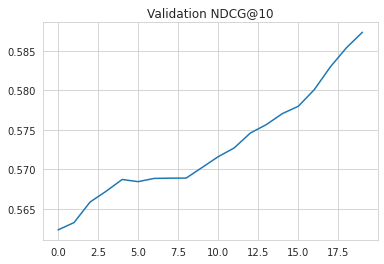

In [42]:
plt.plot(ndcg_val)
plt.title("Validation NDCG@10")

#from google.colab import files
plt.savefig(model_dir + "ndcg.png")
#files.download(model_dir + "ndcg.png") 

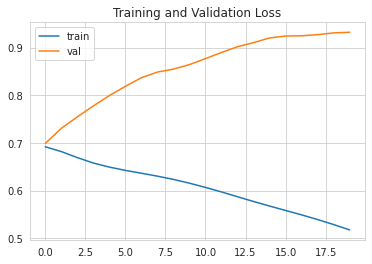

In [43]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend()
plt.title("Training and Validation Loss")

#from google.colab import files
plt.savefig(model_dir + "loss.png")
#files.download(model_dir + "loss.png") 

## **BERT**: Get predictions

In [205]:
data_interaction_test = data_interaction_test.loc[data_interaction_test.user_id.isin([45, 332])]

In [206]:
batch_size= 32
res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
dataset_test= LFM2bDataset(data_interaction_test,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
#dataset_test= LFM2bDatasetMulitpleText(data_interaction_test,tokenizer,item_text_embeddings_size,  item2pos, user2id)
dataloader_test=DataLoader(dataset=dataset_test,batch_size=batch_size, num_workers=4)

#model = AMARBert( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)
#model.load_state_dict(torch.load(model_dir + 'best_model.pth'))
#model.to(device)
model.eval()


for data in dataloader_test:
      gc.collect()
      torch.cuda.empty_cache()
      #items positions
      curr_items_ids_batch = data['track_id']
      # items descriptions
      curr_items_batch = data['input_ids_lyrics']
      curr_attentions_batch = data['attention_mask_lyrics']

      # additional items descriptions
      # curr_items_batch1 = data['input_ids_tags']
      # curr_attentions_batch1 = data['attention_mask_tags']
      
      # users ids
      curr_users_batch =data['user_id']

      # model inputs
      inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
                curr_items_batch.type(torch.LongTensor).to(device), 
                curr_users_batch.type(torch.LongTensor).to(device), 
                curr_attentions_batch.type(torch.LongTensor).to(device),
                # curr_items_batch1.type(torch.LongTensor).to(device), 
                # curr_attentions_batch1.type(torch.LongTensor).to(device),
                ]


      with torch.no_grad():
        outputs = model(inputs)


      # save prediction for each user
      for i in range(outputs.shape[0]):

        res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs[i].item()} , index=[0]))
        

In [207]:
res[(res.user_id == 45)].sort_values('count', ascending = False)#.head(10)

,user_id,track_id,count
0,45,8189,0.592548
0,45,4708,0.592408
0,45,40478,0.592261
0,45,7303,0.592163
0,45,7833,0.592005
...,...,...,...
0,45,520,0.452450
0,45,49220,0.452412
0,45,4154,0.452126
0,45,5347,0.451725


In [208]:
res[res.user_id == 332].sort_values('count', ascending = False)#.head(10) 

,user_id,track_id,count
0,332,8189,0.533291
0,332,4708,0.533146
0,332,40478,0.532995
0,332,7303,0.532894
0,332,7833,0.532731
...,...,...,...
0,332,49220,0.393630
0,332,1042,0.393366
0,332,4154,0.393354
0,332,5347,0.392968


In [ ]:
topn=100
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user, user_prediction in res.groupby('user_id'):
    results_df = results_df.append(user_prediction.sort_values('count', ascending=False).head(topn))
    

In [ ]:
from google.colab import files

results_df.to_csv(model_dir + 'predictions.csv', encoding = 'utf-8-sig') 
#files.download(f'predictions_{text_col}.csv')


# Most popular recommendation


In [202]:
topn = 100

item_popularity_df = data_interaction_test.groupby(item_col)[rating_col].sum().sort_values(ascending=False).reset_index()

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train[user_col] == real_user_id]['track_id'].values
    item_popularity_df_user = item_popularity_df[~item_popularity_df[item_col].isin(items_to_ignore)]
    predictions[real_user_id].append(item_popularity_df_user.head(topn)[item_col].values.tolist())

In [200]:
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
        results.append([user, item, rating])

# Random recommendation

In [94]:
topn = 100

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train[user_col] == real_user_id][item_col].values
    item_df_user = data_interaction_test[~data_interaction_test[item_col].isin(items_to_ignore)]
    predictions[real_user_id].append(random.sample(set(item_df_user['track_id'].values), topn))

In [95]:
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
        results.append([user, item, rating])

# Evaluate predictions

Scores: F1@10, ndcg@k, recall@k

In [ ]:
topn=100

In [ ]:
#results_df = pd.read_csv(model_dir + "predictions.csv").drop(["Unnamed: 0"], axis=1)

In [ ]:
f1_scores = []
recall_scores = []
ndcg_scores = []

for user, df in results_df.groupby(user_col):
  df = df.drop_duplicates(subset=item_col)

  y_true_sorted = data_interaction_test.loc[data_interaction_test[user_col] == user].sort_values(rating_col, ascending=False).drop_duplicates()
  rel = pd.merge(df[[item_col]], y_true_sorted[[item_col, rating_col]].drop_duplicates(), 'left').fillna(0)['count'].values
  y_true_df = pd.merge(data_items_eval[[item_col]].drop_duplicates(), y_true_sorted[[item_col, rating_col]].drop_duplicates(), 'left').fillna(0)
  y_true_ndcg = y_true_df[rating_col].values
  y_true_df.loc[y_true_df[rating_col] > 0, rating_col] = 1
  y_true = y_true_df[rating_col].values

  y_pred_df = pd.merge(data_items_eval[[item_col]].drop_duplicates(), df[[item_col, rating_col]], 'left').fillna(0)
  y_pred_ndcg = y_pred_df[rating_col].values
  y_pred_df.loc[y_pred_df[rating_col] > 0, rating_col] = 1
  y_pred = y_pred_df[rating_col].values

  if y_true.sum() >= 1:
    f1_scores.append(f1_score(y_true, y_pred))
    recall_scores.append(recall_score(y_true, y_pred))
    ndcg_scores.append(get_ndcg(df, rel, topn))

print("F1 Score: ", np.mean(f1_scores))
print("Recall Score: ", np.mean(recall_scores))
print("NDCG Score: ", np.mean(ndcg_scores))

In [ ]:
pd.DataFrame({"f1_score": [np.mean(f1_scores)], 'recall': [np.mean(recall_scores)], 'ndcg': [np.mean(ndcg_scores)]}).to_csv(model_dir + 'evaluation_result.csv', encoding = 'utf-8-sig') 

# Interpretability of Gender Bias

- Find correlations between user gender and item gender (Pearsons correlation)
- For each track get proportion of female/male user => compare train and recommendataion data
- Check if genderness increased/decreased in recommendations (in comparision to training data) 
- Compare distribution of genderness between history and recommendations 
  - "Delta Metric of Genderness" (https://arxiv.org/pdf/2108.06973.pdf)
  - Proportion tests: Fisher exact test, Chi-Square



# Get feature vectors

In [107]:
def get_feature_vector(model, inputs, batch_size):

  layer = model._modules.get('model1_layer3')

  embedding = torch.zeros((batch_size, 128))
  def copy_data(m, i, o):
          embedding.copy_(o.data)
  h = layer.register_forward_hook(copy_data)
  model(inputs)
  h.remove()
  return embedding

In [106]:
model._modules.get('model1_layer2').embeddings.word_embeddings(dataset_test[4]['input_ids_lyrics']

tensor([-0.0015,  0.0037, -0.0133, -0.0152, -0.0010, -0.0076, -0.0076, -0.0095,
        -0.0029,  0.0014,  0.0008, -0.0029, -0.0028, -0.0014, -0.0106, -0.0149,
         0.0073,  0.0058, -0.0029, -0.0028,  0.0044, -0.0121, -0.0149, -0.0152,
        -0.0006,  0.0037, -0.0133, -0.0152, -0.0010, -0.0076, -0.0076, -0.0095,
        -0.0029,  0.0014,  0.0008, -0.0141,  0.0053,  0.0016, -0.0058,  0.0028,
        -0.0113,  0.0073, -0.0068,  0.0037, -0.0058, -0.0145, -0.0016, -0.0115,
        -0.0003,  0.0002,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,
         0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,
         0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,
         0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,
         0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,
         0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,  0.0080,
         0.0080,  0.0080,  0.0080,  0.00

In [105]:
model._modules.get('model1_layer2').embeddings.word_embeddings(dataset_test[1]['input_ids_lyrics']

tensor([-0.0015, -0.0078,  0.0053, -0.0180, -0.0078,  0.0028, -0.0078,  0.0053,
        -0.0180, -0.0078,  0.0053,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041,
        -0.0113, -0.0078,  0.0053,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041,
        -0.0113, -0.0078,  0.0053,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041,
        -0.0113, -0.0078,  0.0053,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041,
        -0.0113, -0.0078,  0.0053, -0.0032,  0.0024,  0.0018, -0.0059, -0.0013,
        -0.0032,  0.0024,  0.0018, -0.0059, -0.0013, -0.0032,  0.0024,  0.0018,
        -0.0059, -0.0013, -0.0032,  0.0024,  0.0018, -0.0059, -0.0013, -0.0078,
         0.0053, -0.0180, -0.0078,  0.0028, -0.0078,  0.0053, -0.0180, -0.0078,
         0.0028,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041, -0.0113, -0.0078,
         0.0053,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041, -0.0113, -0.0078,
         0.0053,  0.0018, -0.0017, -0.0029,  0.0097,  0.0041, -0.0113, -0.0078,
         0.0053,  0.0018, -0.0017, -0.00

In [118]:
feature_vectors = pd.DataFrame()
batch_size= 12
dataset_test= LFM2bDataset(data_interaction_test,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
#dataset_test= LFM2bDatasetMulitpleText(data_interaction_test,tokenizer,item_text_embeddings_size,  item2pos, user2id)
dataloader_test=DataLoader(dataset=dataset_test,batch_size=batch_size, num_workers=4)

#model = AMARBert( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)
#model.load_state_dict(torch.load(model_dir + 'best_model.pth'))
#model.to(device)
model.eval()


for data in dataloader_test:
  #items positions
  curr_items_ids_batch = data['track_id']
  # items descriptions
  curr_items_batch = data['input_ids_lyrics']
  curr_attentions_batch = data['attention_mask_lyrics']

  # additional items descriptions
  # curr_items_batch1 = data['input_ids_tags']
  # curr_attentions_batch1 = data['attention_mask_tags']

  # users ids
  curr_users_batch =data['user_id']

  # model inputs
  inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
            curr_items_batch.type(torch.LongTensor).to(device), 
            curr_users_batch.type(torch.LongTensor).to(device), 
            curr_attentions_batch.type(torch.LongTensor).to(device),
            # curr_items_batch1.type(torch.LongTensor).to(device), 
            # curr_attentions_batch1.type(torch.LongTensor).to(device),
            ]


  with torch.no_grad():
    outputs = model(inputs)

    
  # save embedding layer for each item

  # save prediction for each user
  item_list=[]
  for i in range(outputs.shape[0]):
    item_list.append(pos2item[curr_items_ids_batch[i].item()])
    
  feature_vector = get_feature_vector(model, inputs, batch_size)
  fv = pd.DataFrame(feature_vector)
  fv.index = item_list
  feature_vectors = feature_vectors.append(fv)
  break
      

In [119]:
feature_vectors

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
7181836,tensor(-0.9593),tensor(-0.9564),tensor(-0.2631),tensor(-0.6188),tensor(-0.0909),tensor(2.9929),tensor(-0.2303),tensor(1.0155),tensor(-0.2628),tensor(0.2371),...,tensor(-0.2805),tensor(-0.4343),tensor(0.2655),tensor(1.3080),tensor(0.1545),tensor(-0.2446),tensor(-0.3638),tensor(-0.4562),tensor(-0.3153),tensor(1.6932)
7181836,tensor(-0.9593),tensor(-0.9564),tensor(-0.2631),tensor(-0.6188),tensor(-0.0909),tensor(2.9929),tensor(-0.2303),tensor(1.0155),tensor(-0.2628),tensor(0.2371),...,tensor(-0.2805),tensor(-0.4343),tensor(0.2655),tensor(1.3080),tensor(0.1545),tensor(-0.2446),tensor(-0.3638),tensor(-0.4562),tensor(-0.3153),tensor(1.6932)
5535776,tensor(-0.8295),tensor(-1.0451),tensor(-0.2393),tensor(-0.6284),tensor(-0.3259),tensor(2.8092),tensor(-0.3594),tensor(0.9218),tensor(-0.0845),tensor(0.3300),...,tensor(-0.3745),tensor(-0.1710),tensor(0.2476),tensor(1.0182),tensor(0.1669),tensor(-0.3138),tensor(-0.3958),tensor(-0.4156),tensor(-0.4366),tensor(1.6423)
4639854,tensor(-0.5844),tensor(-0.9787),tensor(-0.2250),tensor(-0.5449),tensor(-0.1729),tensor(3.0936),tensor(-0.3469),tensor(1.1304),tensor(-0.4127),tensor(0.2935),...,tensor(-0.0138),tensor(-0.2925),tensor(0.2143),tensor(1.0135),tensor(0.3513),tensor(-0.4988),tensor(-0.0934),tensor(-0.6427),tensor(-0.2104),tensor(1.3427)
5091428,tensor(-0.9551),tensor(-0.8495),tensor(-0.2438),tensor(-0.7153),tensor(-0.1354),tensor(3.2219),tensor(-0.0375),tensor(1.0253),tensor(-0.1935),tensor(0.3082),...,tensor(-0.1991),tensor(-0.0455),tensor(0.3045),tensor(1.1789),tensor(0.3833),tensor(-0.5899),tensor(-0.7586),tensor(-0.4749),tensor(-0.1032),tensor(1.4633)
5370862,tensor(-0.7373),tensor(-1.0910),tensor(-0.2242),tensor(-0.6785),tensor(-0.3688),tensor(3.0624),tensor(-0.2591),tensor(1.0759),tensor(-0.1179),tensor(0.1674),...,tensor(-0.2093),tensor(-0.2922),tensor(0.3841),tensor(0.8870),tensor(0.1628),tensor(-0.4264),tensor(-0.3822),tensor(-0.4631),tensor(-0.3250),tensor(1.5382)
4967154,tensor(-0.9158),tensor(-0.8307),tensor(-0.3312),tensor(-0.6444),tensor(-0.1918),tensor(3.0853),tensor(-0.0609),tensor(1.1651),tensor(-0.1460),tensor(0.3332),...,tensor(-0.1690),tensor(-0.2460),tensor(0.2113),tensor(1.0323),tensor(0.3238),tensor(-0.5161),tensor(-0.3837),tensor(-0.2755),tensor(-0.0709),tensor(1.6676)
4083259,tensor(-0.8931),tensor(-0.9003),tensor(-0.1996),tensor(-0.6670),tensor(-0.1202),tensor(3.0824),tensor(-0.1430),tensor(1.1670),tensor(-0.2710),tensor(0.3102),...,tensor(-0.0833),tensor(-0.3216),tensor(0.1405),tensor(1.1581),tensor(0.1870),tensor(-0.4553),tensor(-0.3499),tensor(-0.4060),tensor(-0.1087),tensor(1.5800)
6858175,tensor(-0.8527),tensor(-0.8429),tensor(-0.2720),tensor(-0.7719),tensor(0.0350),tensor(2.9121),tensor(-0.0942),tensor(1.1287),tensor(-0.2868),tensor(0.2632),...,tensor(-0.1253),tensor(-0.2737),tensor(0.0019),tensor(1.0889),tensor(0.2285),tensor(-0.4603),tensor(-0.2836),tensor(-0.4493),tensor(-0.0269),tensor(1.6497)
3260786,tensor(-0.8765),tensor(-0.8900),tensor(-0.3294),tensor(-0.7750),tensor(-0.1682),tensor(2.9903),tensor(-0.1942),tensor(0.9300),tensor(-0.0924),tensor(0.3712),...,tensor(-0.2995),tensor(-0.2625),tensor(0.1407),tensor(0.9889),tensor(0.0236),tensor(-0.3401),tensor(-0.2951),tensor(-0.5115),tensor(-0.3492),tensor(1.4995)


## Data

In [ ]:
%cd /content/drive/MyDrive/Master\ Thesis/data

In [62]:
data_predictions = pd.read_csv("predictions_lyrics_tags.csv").drop(['Unnamed: 0'],axis=1)
topn=100
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user, user_prediction in data_predictions.groupby('user_id'):
    results_df = results_df.append(user_prediction.sort_values('count', ascending=False).head(topn))
    

In [66]:
data_interaction_new = results_df.merge(data_items_eval, on = 'track_id')

In [67]:
data_interaction_new[data_interaction_new.user_id == 119741]

,user_id,track_id,count,track_artist,track_name,track_lyrics,lyrics_cleaned,language,track_tag,tags,abstract
213,119741,3981360,0.847441,oneohtrix point never,age of,Blow the wind southerly\nBlow the wind souther...,blow the wind southerly blow the wind southerl...,en,"{'goosebumps': 100, 'neo-renaissance': 100, 'i...",goosebumps neo-renaissance industrial roccoco,"daniel lopatin , best known by the recording a..."
443,119741,4499794,0.817704,divine,alphabet rap,"(A, B, C, D\nA\nA)\n\nA, B, C, D, E, F, G\nH, ...",a b c d a a a b c d e f g h i j k elementary ...,en,"{'dance': 100, 'male vocalists': 100, 'swearin...",dance male vocalists swearing Hi-NRG expletive...,chaos divine is a progressive metal band from ...
673,119741,6450105,0.804637,midge ure,become,Come stand beside me\nCome gather 'round me\nC...,come stand beside me come gather round me come...,en,"{'pop': 100, 'british': 100, 'Scottish': 100, ...",pop british Scottish 2014 2014 single hyperten...,"james ure obe is a scottish musician, singer-..."
901,119741,3406057,0.797154,kishi bashi,a song for you,A song for you\nI wrote in memory\nAs faint as...,a song for you i wrote in memory as faint as a...,en,{'fip': 100},fip,"kaoru ishibashi , who performs as kishi bashi,..."
1121,119741,3985740,0.798931,mayhem,agenda ignis,Burned alive\nIn purgatory flames\nBuried aliv...,burned alive in purgatory flames buried alive ...,en,"{'black metal': 100, 'metal': 50}",black metal metal,natalie ann cohen known by her stage name as ...
...,...,...,...,...,...,...,...,...,...,...,...
21376,119741,6118320,0.756475,leroy smart,ballistic affair,Ballistic affair\nBallistic affair\n\nWe used ...,ballistic affair ballistic affair we used to l...,en,"{'reggae': 100, 'roots reggae': 42, 'Ballistic...",reggae roots reggae Ballistic Affair Riddim ba...,leroy smart is a reggae singer and producer.
21847,119741,3247416,0.749432,brenda lee,a good man is hard to find,A good man is hard to find\nYou always get the...,a good man is hard to find you always get the ...,en,"{'oldies': 100, 'Brenda Lee': 67, 'female': 34...",oldies Brenda Lee female 60s Fizzy Cocktails i...,"brenda lee eager is an american soul singer, ..."
22545,119741,4849832,0.747796,sun ra,angels and demons at play,"Angels, demons, play (Angels, demons, play)\nD...",angels demons play demons angels sing a rare r...,en,"{'jazz': 100, 'free jazz': 50, 'june 2006 bere...",jazz free jazz june 2006 berep tag pre1960s tr...,"le sony'r ra , better known as sun ra, was an ..."
22610,119741,6420826,0.749894,darlene zschech,beautiful saviour,All my days I will sing the song of gladness\n...,all my days i will sing the song of gladness g...,en,"{'pop': 100, 'christian': 50, 'hymns': 50, 'He...",pop christian hymns Heavenly Manna Christian P...,darlene joyce zschech is an australian pentec...


In [106]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)


,track_artist,gender_artist,track_name,track_lyrics,lyrics_cleaned,language,track_id,track_tag
0,aaliyah,female,at your best (you are loved),(One-two checka\nBaby let me know what's up)\n...,one two checka baby let me know what s up if ...,en,5415248,"{'whtd-FM': 100, 'wjlb-FM': 100}"
1,aaliyah,female,aaliyah & timberland-we need a resolution,"Ah, ah\nI'm tired of arguin', girl\nI'm tired,...",ah ah i m tired of arguin girl i m tired i m t...,en,3630918,"{'female vocalists': 100, 'rnb': 100, 'bang': ..."
2,abbey lincoln,female,ain't nobody's business,Ain't nobody's business what I do\nGet me a sh...,ain t nobody s business what i do get me a sho...,en,4063721,"{'jazz vocal': 100, 'female vocalists': 100, '..."
3,abbey lincoln,female,being me,All along the way there were things to do\nAlw...,all along the way there were things to do alwa...,en,6553435,"{'jazz': 100, 'jazz vocal': 100, 'Blues Bar': ..."
4,abbey lincoln,female,and how i hoped for your love,And I thought that life\nWould be so cold\nI t...,and i thought that life would be so cold i tho...,en,4757037,"{'jazz': 100, 'jazz vocal': 100, 'vocal jazz':..."
...,...,...,...,...,...,...,...,...
10099,the teardrop explodes,male,bent out of shape,All my life I've been bent outta shape\nCan't ...,all my life i ve been bent outta shape can t y...,en,6634365,"{'post-punk': 100, 'Post punk': 100, 'space ro..."
10100,the new seekers,female,beautiful people,Beautiful people\nYou live in the same world a...,beautiful people you live in the same world as...,en,6419163,"{'pop': 100, 'oldies': 100, 'Beautiful Songs':..."
10101,tony toni toné,male,all my love,"All my love (all my love, yeah)\nAll my love (...",all my love all my love here’s a little thing ...,en,4316933,"{'rnb': 100, '90s Rnb': 50, 'tony toni tone': ..."
10102,tony toni toné,male,all the way,"Ay boys…\nYes, ma’am\nIs we gon’ record anothe...",ay boys… yes ma’am is we gon’ record another a...,en,4400596,{'New Soul - Hip Hop - Rap': 100}


In [ ]:
data_all_info = data_all_info[['track_artist', 'gender_artist', 'track_id']]

In [69]:
data_user = pd.read_csv("data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user.columns = ['user_id', 'gender_user']

In [119]:
data_classification = data_all_info
replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
#data_classification['gender_user'] = data_classification['gender_user'].replace(replace_dict1)
data_classification['gender_artist'] = data_classification['gender_artist'].replace(replace_dict2)
data_classification = data_classification.merge(data_tracks_tags_lyrics[['track_id', 'tags', 'abstract']], on = 'track_id')
data_classification

,track_artist,gender_artist,track_name,track_lyrics,lyrics_cleaned,language,track_id,track_tag,tags,abstract
0,aaliyah,1,at your best (you are loved),(One-two checka\nBaby let me know what's up)\n...,one two checka baby let me know what s up if ...,en,5415248,"{'whtd-FM': 100, 'wjlb-FM': 100}",whtd-FM wjlb-FM,"aaliyah dana haughton , known mononymously as ..."
1,aaliyah,1,aaliyah & timberland-we need a resolution,"Ah, ah\nI'm tired of arguin', girl\nI'm tired,...",ah ah i m tired of arguin girl i m tired i m t...,en,3630918,"{'female vocalists': 100, 'rnb': 100, 'bang': ...",female vocalists rnb bang Timbaland,"aaliyah dana haughton , known mononymously as ..."
2,abbey lincoln,1,ain't nobody's business,Ain't nobody's business what I do\nGet me a sh...,ain t nobody s business what i do get me a sho...,en,4063721,"{'jazz vocal': 100, 'female vocalists': 100, '...",jazz vocal female vocalists jazz vocals 50s le...,"anna marie wooldridge , known professionally a..."
3,abbey lincoln,1,being me,All along the way there were things to do\nAlw...,all along the way there were things to do alwa...,en,6553435,"{'jazz': 100, 'jazz vocal': 100, 'Blues Bar': ...",jazz jazz vocal Blues Bar jazzy women love is ...,"anna marie wooldridge , known professionally a..."
4,abbey lincoln,1,and how i hoped for your love,And I thought that life\nWould be so cold\nI t...,and i thought that life would be so cold i tho...,en,4757037,"{'jazz': 100, 'jazz vocal': 100, 'vocal jazz':...",jazz jazz vocal vocal jazz fip abbey lincoln,"anna marie wooldridge , known professionally a..."
...,...,...,...,...,...,...,...,...,...,...
4094,some girls,0,all my friends are going death,All my friends are going death\nAnd breathing'...,all my friends are going death and breathing s...,en,4314247,"{'screamo': 100, 'hardcore': 34, 'mathcore': 3...",screamo hardcore mathcore Good Stuff less than...,some girls was an american hardcore punk band ...
4095,some girls,0,beautiful rune,As sun and dove devr bat and moon-\nIf we stay...,as sun and dove devr bat and moon if we stay o...,en,6420589,"{'grindcore': 100, 'hardcore': 50, 'mathcore':...",grindcore hardcore mathcore noisecore religion...,some girls was an american hardcore punk band ...
4096,circus maximus,0,architect of fortune,Conscious all day\nCautious in my own way\nCoi...,conscious all day cautious in my own way coinc...,en,5150508,"{'Progressive metal': 100, 'epic': 67, 'metal'...",Progressive metal epic metal norwegian 6 of 10...,circus maximus is a norwegian progressive meta...
4097,monster movie,0,a place in the mountains,Crushed into the ground\nI don't know if it's ...,crushed into the ground i don t know if it s g...,en,3361068,"{'indie': 100, 'favs': 100}",indie favs,monster movie is a british dream pop band orig...


In [70]:
df_tmp = pd.merge(data_interaction_train, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_train = df_all[df_all['count'] == 1]

In [71]:
df_tmp = pd.merge(data_interaction_test, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_test = df_all[df_all['count'] == 1]

In [72]:
df_tmp = pd.merge(results_df, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_rec = df_all

## Distribution of gender

In [73]:
print(f"In the history data, {round(df_train.gender_artist.sum() / len(df_train) * 100, 2)} % female items were consumed.")
print(f"In the test data, {round(df_test.gender_artist.sum() / len(df_test) * 100, 2)} % female items were consumed.")
print(f"In the recommendation data, {round(df_rec.gender_artist.sum() / len(df_rec) * 100, 2)} % female items were recommended.")

In the history data, 24.71 % female items were consumed.
In the test data, 23.28 % female items were consumed.
In the recommendation data, 31.72 % female items were recommended.


## Correlation between user and item gender

In [74]:
# Proportion of female items in all female user
prop_female = 0
# Proportion of female items in all male user
prop_male = 0
for group, df in df_train.groupby('gender_user'):
  if group == 0:
    prop_male = df.gender_artist.sum() / len(df)
  else:
    prop_female = df.gender_artist.sum() / len(df)

print(f'In the history data, all female users listen to {round(prop_female*100, 2)} % female items.')
print(f'In the history data, all male users listen to {round(prop_male*100, 2)} % female items.')

# Phi correlation (http://web.pdx.edu/~newsomj/pa551/lectur15.htm)
print('The attributes gender_user and gender_artist show a correlation of ', df_train.gender_user.corr(df_train.gender_artist))

In the history data, all female users listen to 37.56 % female items.
In the history data, all male users listen to 22.76 % female items.
The attributes gender_user and gender_artist show a correlation of  0.11613795067442945


In [75]:
# Proportion of female items in all female user
prop_female = 0
# Proportion of female items in all male user
prop_male = 0
for group, df in df_rec.groupby('gender_user'):
  if group == 0:
    prop_male = df.gender_artist.sum() / len(df)
  else:
    prop_female = df.gender_artist.sum() / len(df)

print(f'In the recommendation data, to all female users {round(prop_female*100, 2)} % female items are recommended.')
print(f'In the recommendation data, to all male users {round(prop_male*100, 2)} % female items are recommended.')

# Phi correlation
print('The attributes gender_user and gender_artist show a correlation of ', df_rec.gender_user.corr(df_rec.gender_artist))

In the recommendation data, to all female users 31.26 % female items are recommended.
In the recommendation data, to all male users 31.77 % female items are recommended.
The attributes gender_user and gender_artist show a correlation of  -0.002958289047425267


## Delta metric of genderness

 For user u_i: (prop_female(rec) - prop_female(history)) / prop_female(history)

 If positive: more female tracks are recommended to the user

In [76]:
prop_female_rec = df_rec.gender_artist.sum() / len(df_rec)
prop_female_history = df_train.gender_artist.sum() / len(df_train)
delta = (prop_female_rec - prop_female_history) / prop_female_history

if delta > 0:
  print(f'The value of delta is {round(delta, 4)} and therefore more female tracks are recommended to user.')
else:
  print(f'The value of delta is {round(delta, 4)} and therefore more male tracks are recommended to user.')

The value of delta is 0.2836 and therefore more female tracks are recommended to user.


## Proportion distribution

In [77]:
prop_all = []
prop_male = []
prop_female = []
for user, df in df_train.groupby('user_id'):
  p = df.gender_artist.sum() / len(df)
  prop_all.append(p)
  if (df.gender_user).all() == 0:
    prop_male.append(p)
  else: prop_female.append(p)

print(f"In the history data, there were on average {round(np.mean(prop_all)*100, 2)} % female items consumed.")
print(f"In the history data, among all male users there were on average {round(np.mean(prop_male)*100, 2)} % female items consumed.")
print(f"In the history data, among all female users there were on average {round(np.mean(prop_female)*100, 2)} % female items consumed.")

In the history data, there were on average 24.64 % female items consumed.
In the history data, among all male users there were on average 22.58 % female items consumed.
In the history data, among all female users there were on average 36.93 % female items consumed.


In [78]:
prop_all = []
prop_male = []
prop_female = []
for user, df in df_rec.groupby('user_id'):
  p = df.gender_artist.sum() / len(df)
  prop_all.append(p)
  if (df.gender_user).all() == 0:
    prop_male.append(p)
  else: prop_female.append(p)

print(f"In the recommendation data, there are on average {round(np.mean(prop_all)*100, 2)} % female items recommended.")
print(f"In the recommendation data, among all male users there are on average {round(np.mean(prop_male)*100, 2)} % female items recommended.")
print(f"In the recommendation data, among all female users there are on average {round(np.mean(prop_female)*100, 2)} % female items recommended.")

In the recommendation data, there are on average 31.72 % female items recommended.
In the recommendation data, among all male users there are on average 31.77 % female items recommended.
In the recommendation data, among all female users there are on average 31.26 % female items recommended.


# BERT classification model

In [79]:
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [80]:
import pickle
import pandas as pd


from smooth_gradient import SmoothGradient
from integrated_gradient import IntegratedGradient

import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import DistilBertConfig, DistilBertTokenizer
from transformers import BertTokenizer, BertModel, AdamW

from IPython.display import display, HTML

In [81]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ArtistDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col):
        super(ArtistDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        
        inputs = tokenizer.encode_plus(
            text1, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['gender_artist'], dtype=torch.float)
            }


In [154]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes=2):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    y, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
    )
    pooled_output = y[:,0,:]
    output = self.drop(pooled_output)
    return self.out(output)

In [83]:
import torch
from torch.nn.functional import softmax

import matplotlib
import matplotlib.pyplot as plt


class SaliencyInterpreter:
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 show_progress=True,
                 **kwargs):

        """
        :param model: nn.Module object - can be HuggingFace's model or custom one.
        :param criterion: torch criterion used to train your model.
        :param tokenizer: HuggingFace's tokenizer.
        :param show_progress: bool flag to show tqdm progress bar.
        :param kwargs:
            encoder: string indicates the HuggingFace's encoder, that has 'embeddings' attribute. Used
                if your model doesn't have 'get_input_embeddings' method to get access to encoder embeddings
        """

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.model.eval()
        self.criterion = criterion
        self.tokenizer = tokenizer
        self.show_progress = show_progress
        self.kwargs = kwargs
        # to save outputs in saliency_interpret
        self.batch_output = None

    def _get_gradients(self, batch):
        # set requires_grad to true for all parameters, but save original values to
        # restore them later
        original_param_name_to_requires_grad_dict = {}
        for param_name, param in self.model.named_parameters():
            original_param_name_to_requires_grad_dict[param_name] = param.requires_grad
            param.requires_grad = True
        embedding_gradients = []
        hooks = self._register_embedding_gradient_hooks(embedding_gradients)

        loss = self.forward_step(batch)

        self.model.zero_grad()
        loss.backward()

        for hook in hooks:
            hook.remove()

        # restore the original requires_grad values of the parameters
        for param_name, param in self.model.named_parameters():
            param.requires_grad = original_param_name_to_requires_grad_dict[param_name]

        return embedding_gradients[0]

    def _register_embedding_gradient_hooks(self, embedding_gradients):
        """
        Registers a backward hook on the
        Used to save the gradients of the embeddings for use in get_gradients()
        When there are multiple inputs (e.g., a passage and question), the hook
        will be called multiple times. We append all the embeddings gradients
        to a list.
        """

        def hook_layers(module, grad_in, grad_out):
            embedding_gradients.append(grad_out[0])

        backward_hooks = []
        embedding_layer = self.get_embeddings_layer()
        backward_hooks.append(embedding_layer.register_backward_hook(hook_layers))
        return backward_hooks

    def get_embeddings_layer(self):
        if hasattr(self.model, "get_input_embeddings"):
            embedding_layer = self.model.get_input_embeddings()
        else:
            encoder_attribute = self.kwargs.get("encoder")
            assert encoder_attribute, "Your model doesn't have 'get_input_embeddings' method, thus you " \
                "have provide 'encoder' key argument while initializing SaliencyInterpreter object"
            embedding_layer = getattr(self.model, encoder_attribute).embeddings
        return embedding_layer

    def colorize(self, instance, skip_special_tokens=False):

        special_tokens = self.special_tokens

        word_cmap = matplotlib.cm.Blues
        prob_cmap = matplotlib.cm.Greens
        template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
        colored_string = ''
        # Use a matplotlib normalizer in order to make clearer the difference between values
        normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(instance['grad'])
        for word, color in zip(instance['tokens'], normalized_and_mapped):
            if word in special_tokens and skip_special_tokens:
                continue
            # handle wordpieces
            word = word.replace("##", "") if "##" in word else ' ' + word
            color = matplotlib.colors.rgb2hex(color[:3])
            colored_string += template.format(color, word)
        colored_string += template.format(0, "    Label: {} |".format(instance['label']))
        prob = instance['prob']
        color = matplotlib.colors.rgb2hex(prob_cmap(prob)[:3])
        colored_string += template.format(color, "{:.2f}%".format(instance['prob']*100)) + '|'
        return colored_string

    @property
    def special_tokens(self):
        """
        Some tokenizers don't have 'eos_token' and 'bos_token' attributes.
        So needed we some trick to get them.
        """
        if self.tokenizer.bos_token is None or self.tokenizer.eos_token is None:
            special_tokens = self.tokenizer.build_inputs_with_special_tokens([])
            special_tokens_ids = self.tokenizer.convert_ids_to_tokens(special_tokens)
            self.tokenizer.bos_token, self.tokenizer.eos_token = special_tokens_ids

        special_tokens = self.tokenizer.eos_token, self.tokenizer.bos_token
        return special_tokens

    def forward_step(self, batch):
        """
        If your model receive inputs in another way or you computing not
         like in this example simply override this method. It should return the batch loss
        :param batch: batch returned by dataloader
        :return: torch.Tensor: batch loss
        """
        input_ids = batch.get('input_ids').to(self.device)
        attention_mask = batch.get("attention_mask").to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        label = torch.argmax(outputs, dim=1)
        batch_losses = self.criterion(outputs, label)
        loss = torch.mean(batch_losses)

        self.batch_output = [input_ids, outputs]

        return loss

    def update_output(self):
        """
        You can also override this method if you want to change the format
         of outputs. (e.g. store just gradients)
        :return: batch_output
        """

        input_ids, outputs, grads = self.batch_output

        probs = softmax(outputs, dim=-1)
        probs, labels = torch.max(probs, dim=-1)

        tokens = [
            self.tokenizer.convert_ids_to_tokens(input_ids_)
            for input_ids_ in input_ids
        ]

        embedding_grads = grads.sum(dim=2)
        # norm for each sequence
        norms = torch.norm(embedding_grads, dim=1, p=1)
        # normalizing
        for i, norm in enumerate(norms):
            embedding_grads[i] = torch.abs(embedding_grads[i]) / norm

        batch_output = []

        iterator = zip(tokens, probs, embedding_grads, labels)

        for example_tokens, example_prob, example_grad, example_label in iterator:
            example_dict = dict()
            # as we do it by batches we has a padding so we need to remove it
            example_tokens = [t for t in example_tokens if t != self.tokenizer.pad_token]
            example_dict['tokens'] = example_tokens
            example_dict['grad'] = example_grad.cpu().tolist()[:len(example_tokens)]
            example_dict['label'] = example_label.item()
            example_dict['prob'] = example_prob.item()
            batch_output.append(example_dict)
        return batch_output

import torch

from tqdm import tqdm



class SmoothGradient(SaliencyInterpreter):
    """
    Interprets the prediction using SmoothGrad (https://arxiv.org/abs/1706.03825)
    Registered as a `SaliencyInterpreter` with name "smooth-gradient".
    """
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 stdev=0.01,
                 num_samples=20,
                 show_progress=True,
                 **kwargs):
        super().__init__(model, criterion, tokenizer, show_progress, **kwargs)
        # Hyperparameters
        self.stdev = stdev
        self.num_samples = num_samples

    def saliency_interpret(self, test_dataloader):

        instances_with_grads = []
        iterator = tqdm(test_dataloader) if self.show_progress else test_dataloader

        for batch in iterator:

            # we will store there batch outputs such as gradients, probability, tokens
            # so as each of them are used in different places, for convenience we will create
            # it as attribute:
            self.batch_output = []
            self._smooth_grads(batch)
            batch_output = self.update_output()
            instances_with_grads.extend(batch_output)

        return instances_with_grads

    def _register_forward_hook(self, stdev: float):
        """
        Register a forward hook on the embedding layer which adds random noise to every embedding.
        Used for one term in the SmoothGrad sum.
        """

        def forward_hook(module, inputs, output):
            # Random noise = N(0, stdev * (max-min))
            scale = output.detach().max() - output.detach().min()
            noise = torch.randn(output.shape).to(output.device) * stdev * scale

            # Add the random noise
            output.add_(noise)

        # Register the hook
        embedding_layer = self.get_embeddings_layer()
        handle = embedding_layer.register_forward_hook(forward_hook)
        return handle

    def _smooth_grads(self, batch):
        total_gradients = None
        for _ in range(self.num_samples):
            handle = self._register_forward_hook(self.stdev)
            grads = self._get_gradients(batch)
            handle.remove()

            # Sum gradients
            if total_gradients is None:
                total_gradients = grads
            else:
                total_gradients = total_gradients + grads

        total_gradients /= self.num_samples

        self.batch_output.append(total_gradients)

In [120]:
data_classification = data_classification.drop_duplicates()

class_0 = data_classification[data_classification['gender_artist'] == 0]
class_1 = data_classification[data_classification['gender_artist'] == 1]
class_count_0, class_count_1 = data_classification['gender_artist'].value_counts()

class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)

In [175]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

dataset_train= ArtistDataset(test_under,tokenizer, 128, 'lyrics_cleaned')

dataloader_train=DataLoader(dataset=dataset_train,batch_size=32)

In [176]:
import gc

gc.collect()

16694

In [126]:
device = 'cuda'

In [177]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased', 
#     num_labels = 2, 
#     output_attentions = False, 
#     output_hidden_states = False, 
# ).to(device)
model = SentimentClassifier().to('cuda')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [178]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 20
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

for epoch_i in range(0, epochs):
    
    losses = []
    model.train()

    for step, batch in enumerate(dataloader_train):

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['target'].type(torch.LongTensor).to(device)
    

        outputs = model(
          input_ids=b_input_ids,
          attention_mask=b_input_mask
        )#['logits']

        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, b_labels)

        losses.append(loss.item())

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

        optimizer.zero_grad()
    print(f"Epoch {epoch_i}, Loss {np.mean(losses)}")


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a ma

Epoch 0, Loss 1.8226519579119567
Epoch 1, Loss 1.4044270931728302
Epoch 2, Loss 0.9796884651221927
Epoch 3, Loss 0.8873458116773575
Epoch 4, Loss 0.8482603662543826
Epoch 5, Loss 0.8135024578798384
Epoch 6, Loss 0.7910786299478441
Epoch 7, Loss 0.7970680925581191
Epoch 8, Loss 0.7825117939048343
Epoch 9, Loss 0.7684355704557329
Epoch 10, Loss 0.7669789687035575
Epoch 11, Loss 0.7592805723349253
Epoch 12, Loss 0.7567148605982462
Epoch 13, Loss 0.7556627771211049
Epoch 14, Loss 0.7291213028014653
Epoch 15, Loss 0.7358230219946967
Epoch 16, Loss 0.7315578583687071
Epoch 17, Loss 0.7226460647015345
Epoch 18, Loss 0.7287267068075756
Epoch 19, Loss 0.721786609244725


In [179]:
outputs

tensor([[-0.2258,  0.0396],
        [-0.3182,  0.0189],
        [-1.1384,  0.0472],
        [-0.1277,  0.3587],
        [-0.7447, -0.2248],
        [-0.2408, -0.5658],
        [-0.1476,  0.0341],
        [ 0.0417, -0.0049],
        [-1.3692, -0.1323],
        [-0.1685,  0.2825],
        [ 0.2048,  0.3669],
        [ 0.0093, -0.2663],
        [-0.6821,  0.4564],
        [-0.9747, -0.3152]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [180]:
integrated_grad = SmoothGradient(
    model, 
    loss_fn, 
    tokenizer, 
    show_progress=False,
    encoder="bert"
)
instances = integrated_grad.saliency_interpret(dataloader_train)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [181]:
words_male = []
words_female = []
for i in range(len(instances)):
  idx = np.argsort(instances[i]['grad'])[::-1][:10]
  if instances[i]['label'] == 0:
    words_male = words_male + [instances[i]['tokens'][val] for val in idx]
  else: 
    words_female = words_female + [instances[i]['tokens'][val] for val in idx]

words_male = [ elem for elem in words_male if elem not in ['[SEP]', '[CLS]']]
words_female = [ elem for elem in words_female if elem not in ['[SEP]', '[CLS]']]

In [182]:
len(words_male)

161

In [183]:
coloder_string = integrated_grad.colorize(instances[1])
display(HTML(coloder_string))

Using bos_token, but it is not set yet.


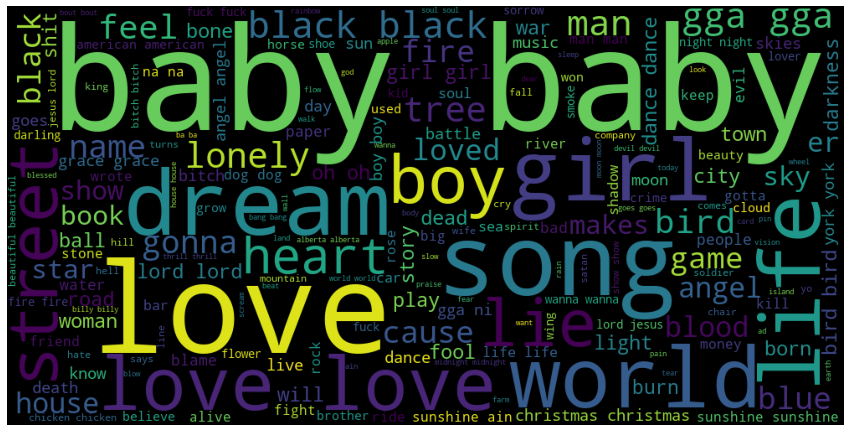

dict_keys(['baby baby', 'love', 'song', 'dream', 'girl', 'world', 'life', 'love love', 'street', 'boy', 'lie', 'heart', 'black black', 'man', 'gga gga', 'tree', 'lonely', 'bird', 'feel', 'name', 'gonna', 'fire', 'black', 'cause', 'blue', 'game', 'loved', 'blood', 'house', 'angel', 'er', 'makes', 'show', 'book', 'star', 'sky', 'girl girl', 'war', 'play', 'woman', 'bird bird', 'town', 'will', 'road', 'dead', 'lord lord', 'born', 'story', 'ball', 'bone', 'fool', 'city', 'light', 'oh oh', 'dance dance', 'burn', 'darkness', 'shit', 'grace grace', 'battle', 'bitch', 'live', 'know', 'gga ni', 'angel angel', 'york york', 'goes', 'death', 'sun', 'christmas christmas', 'music', 'dance', 'moon', 'day', 'skies', 'boy boy', 'blame', 'bad', 'water', 'evil', 'paper', 'people', 'soul', 'bar', 'sea', 'car', 'shadow', 'life life', 'alive', 'ride', 'fight', 'gotta', 'wrote', 'stone', 'big', 'friend', 'money', 'kill', 'river', 'rock', 'rose', 'keep', 'dog dog', 'na na', 'man man', 'sunshine sunshine', 'su

In [184]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(words_female)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

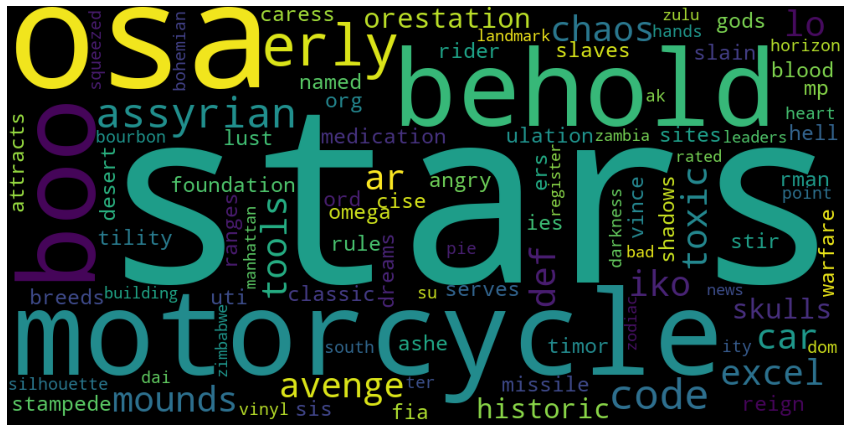

dict_keys(['stars', 'osa', 'motorcycle', 'behold', 'boo', 'erly', 'assyrian', 'code', 'chaos', 'avenge', 'toxic', 'car', 'excel', 'lo', 'tools', 'ar', 'mounds', 'iko', 'def', 'orestation', 'skulls', 'historic', 'breeds', 'blood', 'dreams', 'stir', 'gods', 'shadows', 'org', 'reign', 'ies', 'hell', 'slaves', 'serves', 'ulation', 'rule', 'ers', 'foundation', 'slain', 'timor', 'fia', 'vince', 'rman', 'uti', 'ord', 'mp', 'sis', 'rider', 'stampede', 'named', 'medication', 'cise', 'tility', 'angry', 'omega', 'attracts', 'warfare', 'sites', 'lust', 'ranges', 'missile', 'classic', 'desert', 'ashe', 'caress', 'silhouette', 'ter', 'horizon', 'hands', 'vinyl', 'ak', 'dai', 'point', 'darkness', 'heart', 'squeezed', 'ity', 'su', 'pie', 'south', 'dom', 'bourbon', 'bohemian', 'building', 'manhattan', 'register', 'landmark', 'news', 'bad', 'zimbabwe', 'zodiac', 'zambia', 'zulu', 'rated', 'leaders'])


In [185]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(words_male)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

# Predict artist gender

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_all_info = data_all_info.loc[data_all_info.artist_gender != 'other' ]

In [ ]:
input = feature_vectors

In [ ]:
df_features = pd.DataFrame()
id_col = []

for id in data_interaction_test[item_col].unique():
  id_col.append(id)
  df_features = df_features.append(pd.DataFrame(input[id][0].detach().numpy()))

df_features[item_col] = id_col

In [ ]:
df_features = pd.merge(df_features, data_all_info)

In [ ]:
df_features.loc[df_features.artist_gender == 'female', 'artist_gender'] = 0
df_features.loc[df_features.artist_gender == 'male', 'artist_gender'] = 1
df_features.artist_gender = df_features.artist_gender.astype('int')

In [ ]:
X = df_features.iloc[:,:128]
y = df_features.artist_gender
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [ ]:
#clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test.values, y_pred))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test.values, y_pred))
print("Recall: ", metrics.recall_score(y_test.values, y_pred))
print("Precision: ", metrics.precision_score(y_test.values, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp.head(10)